In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import gc
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## Torchvision
import torchvision
from torchvision import transforms

## Augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

import cv2

## Utils
import joblib
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
CONFIG = {
    'img_size': 448,
    'seed': 22,
    'n_fold': 5,
    'train_batch_size': 32,
    'test_batch_size': 64,
    'num_classes': 15587,
    'patches_size': 32,
    'device': torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
}

In [4]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [5]:
ROOT_DIR = '../input/happy-whale-and-dolphin'
TRAIN_DIR = '../input/happy-whale-and-dolphin/train_images'
TEST_DIR = '../input/happy-whale-and-dolphin/test_images'

In [6]:
def get_train_file_path(id):
    return f"{TRAIN_DIR}/{id}"

In [7]:
df = pd.read_csv(f"{ROOT_DIR}/train.csv")
df['file_path'] = df['image'].apply(get_train_file_path)
df.head()

,image,species,individual_id,file_path
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9,../input/happy-whale-and-dolphin/train_images/...
1,000562241d384d.jpg,humpback_whale,1a71fbb72250,../input/happy-whale-and-dolphin/train_images/...
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b,../input/happy-whale-and-dolphin/train_images/...
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063,../input/happy-whale-and-dolphin/train_images/...
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392,../input/happy-whale-and-dolphin/train_images/...


In [8]:
encoder = LabelEncoder()
df['individual_id'] = encoder.fit_transform(df['individual_id'])

with open("le.pkl", "wb") as fp:
    joblib.dump(encoder, fp)

In [9]:
df.head()

,image,species,individual_id,file_path
0,00021adfb725ed.jpg,melon_headed_whale,12348,../input/happy-whale-and-dolphin/train_images/...
1,000562241d384d.jpg,humpback_whale,1636,../input/happy-whale-and-dolphin/train_images/...
2,0007c33415ce37.jpg,false_killer_whale,5842,../input/happy-whale-and-dolphin/train_images/...
3,0007d9bca26a99.jpg,bottlenose_dolphin,4551,../input/happy-whale-and-dolphin/train_images/...
4,00087baf5cef7a.jpg,humpback_whale,8721,../input/happy-whale-and-dolphin/train_images/...


In [10]:
class HappyWhaleDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.labels = df['individual_id'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.labels[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'label': torch.tensor(label, dtype=torch.long)
        }

In [11]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.ShiftScaleRotate(shift_limit=0.1, 
                           scale_limit=0.15, 
                           rotate_limit=60, 
                           p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.),
    
    "test": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

In [12]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
    return x

In [13]:
class AttentionBlock(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads,
                                          dropout=dropout)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )


    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

In [14]:
class VisionTransformer(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_channels, num_heads, num_layers, num_classes, patch_size, num_patches, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels*(patch_size**2), embed_dim)
        self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers)])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1,1+num_patches,embed_dim))


    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding[:,:T+1]

        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

In [15]:
CONFIG['device']

device(type='cuda', index=0)

In [16]:
model = VisionTransformer(**{
        'embed_dim': 784,
        'hidden_dim': 1568,
        'num_heads': 8,
        'num_layers': 6,
        'patch_size': 32,
        'num_channels': 3,
        'num_patches': 196,
        'num_classes': CONFIG['num_classes'],
        'dropout': 0.2
    }
)
model.to(CONFIG['device'])

VisionTransformer(
  (input_layer): Linear(in_features=3072, out_features=784, bias=True)
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((784,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=784, out_features=784, bias=True)
      )
      (layer_norm_2): LayerNorm((784,), eps=1e-05, elementwise_affine=True)
      (linear): Sequential(
        (0): Linear(in_features=784, out_features=1568, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=1568, out_features=784, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
    (1): AttentionBlock(
      (layer_norm_1): LayerNorm((784,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=784, out_features=784, bias=True)
      )
      (layer_norm_2): L

In [17]:
train_dataset = HappyWhaleDataset(df, transforms=data_transforms["train"])
train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], num_workers=2, shuffle=True, drop_last=True)

In [18]:
# criterion + optimizer + scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-5)
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[8, 12], gamma=0.1)

In [19]:
training_loss = []

In [20]:
def load_model(path):
    model = VisionTransformer(**{
            'embed_dim': 784,
            'hidden_dim': 1568,
            'num_heads': 8,
            'num_layers': 6,
            'patch_size': 32,
            'num_channels': 3,
            'num_patches': 196,
            'num_classes': CONFIG['num_classes'],
            'dropout': 0.2
        }
    )
    model.to(CONFIG['device'])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=3e-5)
    lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[8, 12], gamma=0.1)

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
    epoch = checkpoint['epoch']
    training_loss = checkpoint['train_loss']
    return model, optimizer, criterion, lr_scheduler, epoch, training_loss    

In [21]:
# model, optimizer, criterion, lr_scheduler, current_epoch, training_loss = load_model('model-e15.pt')

In [22]:
start_epoch = 0
end_epoch = start_epoch + 5
for epoch in range(start_epoch, end_epoch):
    train_epoch_loss = 0
    gc.collect()
    model.train()
    bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, batch in bar:
        X_train_batch, y_train_batch = batch['image'], batch['label']
        X_train_batch = X_train_batch.to(CONFIG['device'])
        y_train_batch = y_train_batch.to(CONFIG['device'])

        optimizer.zero_grad()

        y_train_pred = model(X_train_batch).squeeze()

        train_loss = criterion(y_train_pred, y_train_batch)
        #train_acc = multi_acc(y_train_pred, y_train_batch)

        train_loss.backward()
        optimizer.step()
        #lr_scheduler.step()

        train_epoch_loss += train_loss.item()
        bar.set_postfix(Epoch=epoch, Train_Loss=train_epoch_loss/len(train_loader),LR=optimizer.param_groups[0]['lr']) 

    training_loss.append(train_epoch_loss/len(train_loader))
    gc.collect()
    

    print(f'Epoch {epoch+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f}')

100%|██████████| 1594/1594 [52:25<00:00,  1.97s/it, Epoch=0, LR=3e-5, Train_Loss=9.01]


Epoch 00: | Train Loss: 9.00877


100%|██████████| 1594/1594 [52:26<00:00,  1.97s/it, Epoch=1, LR=3e-5, Train_Loss=8.36]


Epoch 01: | Train Loss: 8.35603


100%|██████████| 1594/1594 [53:03<00:00,  2.00s/it, Epoch=2, LR=3e-5, Train_Loss=7.96]


Epoch 02: | Train Loss: 7.96117


100%|██████████| 1594/1594 [52:54<00:00,  1.99s/it, Epoch=3, LR=3e-5, Train_Loss=7.64]


Epoch 03: | Train Loss: 7.63960


100%|██████████| 1594/1594 [53:11<00:00,  2.00s/it, Epoch=4, LR=3e-5, Train_Loss=7.37]


Epoch 04: | Train Loss: 7.36681


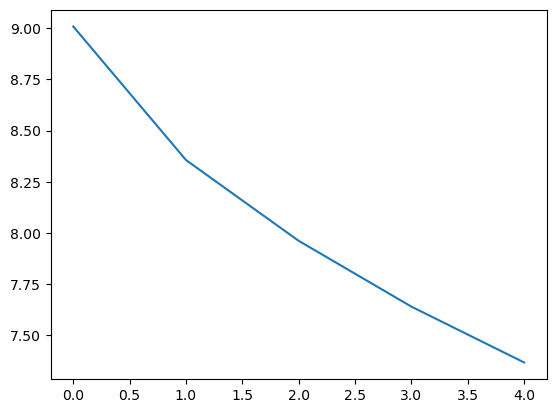

In [23]:
plt.plot(training_loss)

In [24]:
def save_model(path):
    torch.save({
                'epoch': 15,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'lr_scheduler_state_dict': lr_scheduler.state_dict(),
                'train_loss': training_loss,
                }, path)


In [25]:
save_model('model-e15.pt')

In [26]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink(r'model-e15.pt')

/kaggle/working


/kaggle/working/model-e15.pt

In [27]:
test_data = []
for dirname, _, filenames in os.walk('/kaggle/input/happy-whale-and-dolphin/test_images'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        test_data.append([filename, path])

In [28]:
df_test = pd.DataFrame(test_data, columns=['filename', 'path'])

In [29]:
df_test

,filename,path
0,cd50701ae53ed8.jpg,/kaggle/input/happy-whale-and-dolphin/test_ima...
1,177269f927ed34.jpg,/kaggle/input/happy-whale-and-dolphin/test_ima...
2,9137934396d804.jpg,/kaggle/input/happy-whale-and-dolphin/test_ima...
3,c28365a55a0dfe.jpg,/kaggle/input/happy-whale-and-dolphin/test_ima...
4,1a40b7b382923a.jpg,/kaggle/input/happy-whale-and-dolphin/test_ima...
...,...,...
27951,ed5868e5fb3eba.jpg,/kaggle/input/happy-whale-and-dolphin/test_ima...
27952,986ecc6cb6959c.jpg,/kaggle/input/happy-whale-and-dolphin/test_ima...
27953,fd19816a92886f.jpg,/kaggle/input/happy-whale-and-dolphin/test_ima...
27954,c58c2f75688a31.jpg,/kaggle/input/happy-whale-and-dolphin/test_ima...


In [30]:
class HappyWhaleTestDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['path'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img
        }

In [31]:
test_dataset = HappyWhaleTestDataset(df_test, transforms=data_transforms['test'])
test_loader = DataLoader(test_dataset, batch_size=CONFIG['test_batch_size'], num_workers=2, shuffle=False)

In [32]:
y_pred_list = []

In [33]:
import itertools
y_pred_list_p = list(itertools.chain(*y_pred_list))

In [34]:
model.eval()
with torch.no_grad():
    bar = tqdm(enumerate(test_loader), total=len(test_loader))
    for step, batch in bar:
        x_batch = batch['image']
        x_batch = x_batch.to(CONFIG['device'])
        y_test_pred = model(x_batch)
        y_test_pred = torch.softmax(y_test_pred, dim = 1)
        y_pred_probs, y_pred_tags = torch.topk(y_test_pred, 5, dim = 1)
        y_pred_probs = y_pred_probs.cpu().numpy()
        y_pred_tags = y_pred_tags.cpu().numpy()
        
        # threshold for new_individual
        y_pred_tags[:, -1][y_pred_probs[:, -1] < 0.7] = -1 # new_individual     
        
        y_pred_list.append(y_pred_tags)

100%|██████████| 437/437 [27:11<00:00,  3.73s/it]


In [35]:
y_pred_list[:2]

[array([[  480,  9483,  7921, 15079,    -1],
        [ 3295,  5624,    85,   830,    -1],
        [ 4909,  7194,  3048,  6710,    -1],
        [13506,  3398,  1082,  1613,    -1],
        [ 3398,  4520, 12567,  1082,    -1],
        [ 5964,  5624,  4047,    85,    -1],
        [ 4715,  4520,   180,  5847,    -1],
        [ 4334,  3398,  2301,  5380,    -1],
        [11492, 14059, 11859,  9688,    -1],
        [ 1082,  4520, 12567, 10092,    -1],
        [15358,  4987,  8246, 14592,    -1],
        [14059, 10192,  9688,   180,    -1],
        [11492,  2119,  4587, 11672,    -1],
        [11492, 14059,  1101, 11859,    -1],
        [ 4909,  3048,  7194, 13383,    -1],
        [ 2119,  4587,  3296, 11672,    -1],
        [11668, 11118, 14010,  2910,    -1],
        [  480, 12461, 14902, 11287,    -1],
        [ 4909,  7194,  3048,  6710,    -1],
        [ 1492,  8077,  1613,  9688,    -1],
        [ 2119,  5017, 12573,  1598,    -1],
        [15079,  2910,  9483, 10638,    -1],
        [1

In [36]:
predictions_col = []

In [37]:
for y_pred_batch in y_pred_list:
    for y_pred_top_5 in y_pred_batch:
        y_pred_string = f'{encoder.inverse_transform([y_pred_top_5[0]])[0]}'
        for y_pred in y_pred_top_5[1:]:
            if y_pred == -1:
                y_pred_string = y_pred_string + '\nnew_individual'
            else:
                y_pred_string = y_pred_string + f'\n{encoder.inverse_transform([y_pred])[0]}'
        predictions_col.append(y_pred_string)

In [38]:
predictions_col[:3]

['07a477b6a091\n9ab8c57f10bc\n814597f508b8\nf7bb4f9a9d1a\nnew_individual',
 '365c8c1b1840\n5ca6e3b0601c\n018aaba90625\n0d11516e7fbe\nnew_individual',
 '51081e431bca\n7593d2aee842\n322a18725969\n6da7ae3c5d54\nnew_individual']

In [39]:
len(predictions_col)

27956

In [40]:
df_submission = df_test.copy()

In [41]:
df_submission.rename(columns={"filename": "image"}, inplace=True)
df_submission.drop(columns=['path'], inplace=True)

In [42]:
df_submission['predictions'] = predictions_col

In [43]:
df_submission.to_csv('./submission_topk.csv', index=False)

In [44]:
df_submission

,image,predictions
0,cd50701ae53ed8.jpg,07a477b6a091\n9ab8c57f10bc\n814597f508b8\nf7bb...
1,177269f927ed34.jpg,365c8c1b1840\n5ca6e3b0601c\n018aaba90625\n0d11...
2,9137934396d804.jpg,51081e431bca\n7593d2aee842\n322a18725969\n6da7...
3,c28365a55a0dfe.jpg,dd8c756c9cb7\n37c7aba965a5\n114207cab555\n19fb...
4,1a40b7b382923a.jpg,37c7aba965a5\n4a67e64bd3b7\nce6e37904aa4\n1142...
...,...,...
27951,ed5868e5fb3eba.jpg,2280b5fcc6c2\n20916df9f20d\n8fd41ec0db01\ncca9...
27952,986ecc6cb6959c.jpg,814597f508b8\nf7bb4f9a9d1a\nb5e1ee74f22b\n70cb...
27953,fd19816a92886f.jpg,f195c38bcf17\naff93d9d3356\nca886e0b34a3\n600a...
27954,c58c2f75688a31.jpg,4a67e64bd3b7\ne69d5f9f8d1e\n02da0e68dccd\n9e89...


# References
- https://www.kaggle.com/code/debarshichanda/pytorch-arcface-gem-pooling-starter
- https://www.kaggle.com/code/jaykumar2862/happy-whale-competition
- https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html
- https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial15/Vision_Transformer.html